### Load packages

In [3]:
import sys
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

import pathlib
import hydra
from hydra import initialize, compose


In [4]:
sys.path.append('../')

In [5]:
from src import table_proc

### Init from conf file

In [6]:
initialize('../src/conf/') # Assume the configuration file is in the current folder
cfg = compose(config_name='train_pop_avg')

In [7]:
cfg

{'img_size': 246, 'img_size': 503, 'segmentation_base_path': './data/preprocessed_data/train/segmented', 'preprocessed_image_base_path': './data/preprocessed_data/train/aligned', 'brixia_score_base_path': './data/preprocessed_data/train/score_original', 'train_table': '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg.csv', 'valid_table': '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg.csv', 'test_table': '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/testClinDataImputedPopAvg.csv', 'raw_output_base': './data/raw_output', 'project': 'ai4covid', 'n_feature_cols': 41, 'visualize': True, 'augment': True, 'batch_size': 9, 'epochs': 47, 'learning_rate': 0.01074, 'steps_per_epoch': 365, 'death_rate': 0.25, 'cross_val_train': True, 'n_folds': 5, 'cv_train_table': '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg_', 'cv_valid_table': '/home/qb

In [9]:
cfg.preprocessed_image_base_path, cfg.train_table, cfg.valid_table

('./data/preprocessed_data/train/aligned',
 '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg.csv',
 '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg.csv')

In [12]:
pd.read_csv( cfg.train_table )

FileNotFoundError: [Errno 2] No such file or directory: '/home/qbeer/GitHub/ai4covid/data/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg.csv'

In [80]:
source_img = './data_local/preprocessed_data/train/aligned/'
source_table = './data/preprocessed_data/tables/pop_sampled/'
files_img = np.array( [ i for i in sorted( os.listdir(source_img) ) ] )
files_table = np.array( [ i for i in sorted( os.listdir(cfg.train_table_path) ) ] )
files_img[:3], files_table

NotADirectoryError: [Errno 20] Not a directory: './data/raw_data/trainClinData.xls'

In [25]:
def load_image(path, resize=False, imgsz=512):
    img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
    
    if resize:
        img = cv2.resize(
            img,
            (imgsz, imgsz),
            interpolation=cv2.INTER_AREA,
        )
    return img

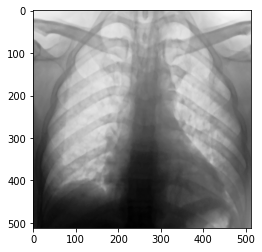

In [26]:
plt.imshow( load_image(source+files[10]), cmap='Greys' )

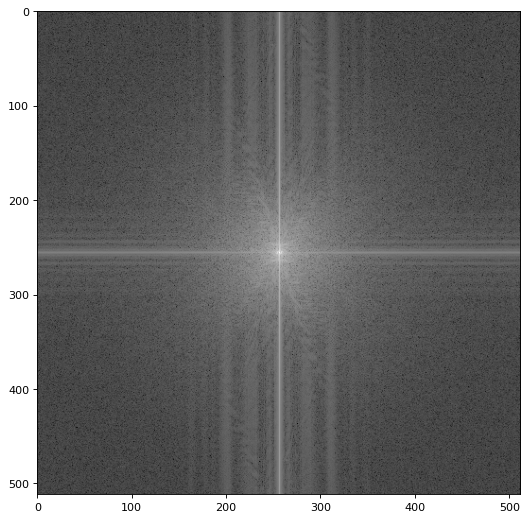

In [28]:
img = load_image(source+files[10])
f = np.fft.fft2(img)
f_s = np.fft.fftshift(f)
plt.figure(num=None, figsize=(10, 8), dpi=80)
plt.imshow(np.log(abs(f_s)), cmap='gray');

In [41]:
np.abs(f[0])

array([3.80211470e+07, 8.96055923e+05, 3.52766033e+06, 3.79246198e+05,
       5.02319234e+05, 1.54397358e+05, 1.58466600e+05, 1.59814804e+05,
       1.14599106e+05, 2.03881190e+05, 9.18946250e+04, 1.51276098e+05,
       7.03291323e+04, 8.29549310e+04, 2.13279348e+04, 6.96915119e+04,
       5.99202508e+04, 4.85339713e+04, 1.03240155e+05, 2.03708876e+04,
       7.59572347e+04, 5.98829932e+04, 6.25432892e+04, 1.92227619e+04,
       5.88428480e+04, 2.27510793e+04, 3.20705180e+04, 5.66762300e+04,
       3.93534488e+04, 2.89023774e+04, 3.27523243e+04, 3.46121136e+04,
       4.69402098e+04, 2.51206631e+04, 3.79516884e+04, 2.35247610e+04,
       3.74494535e+04, 3.10053886e+04, 4.49004630e+04, 2.51100452e+04,
       3.08982626e+04, 1.62467207e+04, 2.86006701e+04, 1.86843405e+04,
       1.83607066e+04, 2.31656545e+04, 2.20175331e+04, 2.52090319e+04,
       1.46647773e+04, 2.57220310e+04, 2.20661922e+04, 1.39273136e+04,
       2.22703785e+04, 1.48243928e+04, 1.92246128e+04, 1.20913770e+04,
      

In [37]:
f

array([[38021147.              +0.j        ,
         -652765.5216069  +613851.27817642j,
         3347278.73187154-1113603.38968025j, ...,
         -325458.90996868 +194689.95049674j,
         3347278.73187154+1113603.38968025j,
         -652765.5216069  -613851.27817642j],
       [ 1535101.28478362+5433479.68185475j,
         -801982.51487087-1863788.74650221j,
        -1489371.61936455 +324501.79396262j, ...,
         -590663.68457948 +876883.92505857j,
        -1822816.69793331 +485834.72121635j,
         -481492.8631654  -146209.6194945j ],
       [ -572411.52351392+2830838.55292038j,
          165171.34810021 -481782.95000084j,
          105853.15979727 -208055.35340085j, ...,
           95964.93406944 -288133.44243216j,
         -299780.22970931 +163765.34920941j,
         -670251.0773438  +400168.02546567j],
       ...,
       [ -464618.67006641-1901545.24516843j,
         -728085.8419021   +11084.51256924j,
           40367.04934375 -135167.87968521j, ...,
          340172.469

In [34]:
abs(f_s)

array([[141.        , 183.39703812,  83.08184858, ...,  63.00992523,
         83.08184858, 183.39703812],
       [100.10246864, 103.05088915,  32.45634398, ...,  90.15219949,
        114.22229535,  90.35234203],
       [ 59.63368625, 250.37475182, 168.17065903, ...,  49.74419735,
        114.82704145,  38.3956102 ],
       ...,
       [ 84.18049801, 135.35678692, 134.68756695, ..., 123.49563145,
        151.29130072, 107.82378977],
       [ 59.63368625,  38.3956102 , 114.82704145, ..., 320.00335693,
        168.17065903, 250.37475182],
       [100.10246864,  90.35234203, 114.22229535, ...,  59.15442298,
         32.45634398, 103.05088915]])